In [1]:
input_file_path = 'redcard.csv.gz'

## This exploration was done by Sean Markert, for the redCard data set. The purpose of the challenge is to check whether or not there is bias against darker skin players, and they recieve more red cards.


- ### The table we have been provided looks at red cards awarded by refs to players. Each row is based off of a ref-player pair.

In [2]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline
plt.style.use( 'dark_background' )
plt.rcParams[ 'figure.figsize' ] = ( 14, 10 )

From the paper link:

playerShort 
- short player ID\

player 
- player name\

club
- player club\

leagueCountry
- country of player club (England, Germany, France, and Spain)\

birthday
- player birthday\

height
- player height (in cm)\

weight
- player weight (in kg)\

position
- detailed player position \

games
- number of games in the player-referee dyad\

victories
- victories in the player-referee dyad\

ties
- ties in the player-referee dyad\

defeats
- losses in the player-referee dyad\

goals
- goals scored by a player in the player-referee dyad\

yellowCards
- number of yellow cards player received from referee\

yellowReds
- number of yellow-red cards player received from referee\

redCards
- number of red cards player received from referee\

photoID
- ID of player photo (if available)\

rater1
- skin rating of photo by rater 1 (5-point scale ranging from \'93very light skin\'94 to '93very dark skin\'94)\

rater2
- skin rating of photo by rater 2 (5-point scale ranging from \'93very light skin\'94 to \'93very dark skin\'94)\

refNum
- unique referee ID number (referee name removed for anonymizing purposes)\

refCountry
- unique referee country ID number (country name removed for anonymizing purposes)\

meanIAT
- mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations \

nIAT
- sample size for race IAT in that particular country\

seIAT
- standard error for mean estimate of race IAT       \

meanExp
- mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks\

nExp
- sample size for explicit bias in that particular country\

seExp
- standard error for mean estimate of explicit bias measure\


The biggest thing we are going to want to look at to answer the question is:
- ### yellowCards
- ### yellowReds
- ### redCards
- ### rater1
- ### rater2

Things that will have a strong effect on this result will be:
- refNum
- refCountry
- meanIAT
- nIAT
- nIAT
- seIAT
- meanExp
- nExp
- seExp

In [3]:
def group_bar_plot( data, column ):
    group = data.groupby( [column] ).size().reset_index()
    group['count'] = group[0]

    fig, ax = plt.subplots( figsize=(14,10) )
    sns.barplot( data=group, x=column, y='count', ax=ax )
    plt.show()

Let's read in the data and have a look at it

In [4]:
raw_df = pd.read_csv( input_file_path )

print( raw_df.shape )
print( raw_df.head() )

(146028, 28)
     playerShort         player             club leagueCountry    birthday  \
0  lucas-wilchez  Lucas Wilchez    Real Zaragoza         Spain  31.08.1983   
1     john-utaka     John Utaka  Montpellier HSC        France  08.01.1982   
2    abdon-prats    Abdón Prats     RCD Mallorca         Spain  17.12.1992   
3     pablo-mari     Pablo Marí     RCD Mallorca         Spain  31.08.1993   
4     ruben-pena     Rubén Peña  Real Valladolid         Spain  18.07.1991   

   height  weight              position  games  victories    ...     rater2  \
0   177.0    72.0  Attacking Midfielder      1          0    ...       0.50   
1   179.0    82.0          Right Winger      1          0    ...       0.75   
2   181.0    79.0                   NaN      1          0    ...        NaN   
3   191.0    87.0           Center Back      1          1    ...        NaN   
4   172.0    70.0      Right Midfielder      1          1    ...        NaN   

   refNum  refCountry  Alpha_3   meanIAT   

That's a lot of players, and a fair amount of features

In [5]:
raw_df.columns.values

array(['playerShort', 'player', 'club', 'leagueCountry', 'birthday',
       'height', 'weight', 'position', 'games', 'victories', 'ties',
       'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards',
       'photoID', 'rater1', 'rater2', 'refNum', 'refCountry', 'Alpha_3',
       'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'],
      dtype=object)

Now let's check for sparsity

In [6]:
raw_df.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

So we are missing some heights, weights, and positions. That shouldn't be too important for the question we were posed. 

The rater data is important for this question, so we will need to fill this data. If there are duplicate players, we can possibly fill these values, or at least use group by's to handle this.

We are also missing some of the implicit bias normalization info. This may be an issue, but again may be able to handle this if there are duplicates in the data.

Let's see if the player id's are unique

In [6]:
print( raw_df['playerShort'].unique().shape[0] == raw_df.shape[0] )
print( raw_df['playerShort'].unique().shape[0]  )
print( raw_df.shape[0] )

False
2053
146028


These are not unique, but likely tied to a player's name. Let's check what kind of numbers we are working with by player.

In [13]:
player_group = raw_df.groupby( 'playerShort' ).size()

print( player_group.head(10) )
print( player_group.sum() == raw_df.shape[0] )

playerShort
aaron-hughes              166
aaron-hunt                 99
aaron-lennon              101
aaron-ramsey              104
abdelhamid-el-kaoutari     37
abdon-prats                33
abdou-dampha               18
abdou-traore_2             42
abdoul-camara              67
abdoulaye-diallo_2         20
dtype: int64
True


Alright, let's do the same for refs.

In [14]:
ref_group = raw_df.groupby( 'refNum' ).size()

print( raw_df['refNum'].unique().shape[0] )
print( ref_group.head(10) )

3147
refNum
1       1
2       1
3       3
4      30
5       1
6       9
7     178
8       1
9       3
10      1
dtype: int64


Some refs only have 1 game! This may make some of the calibrating for biases difficult if there is missing data.

Let's move to visualizing some of these.

We will start with red cards

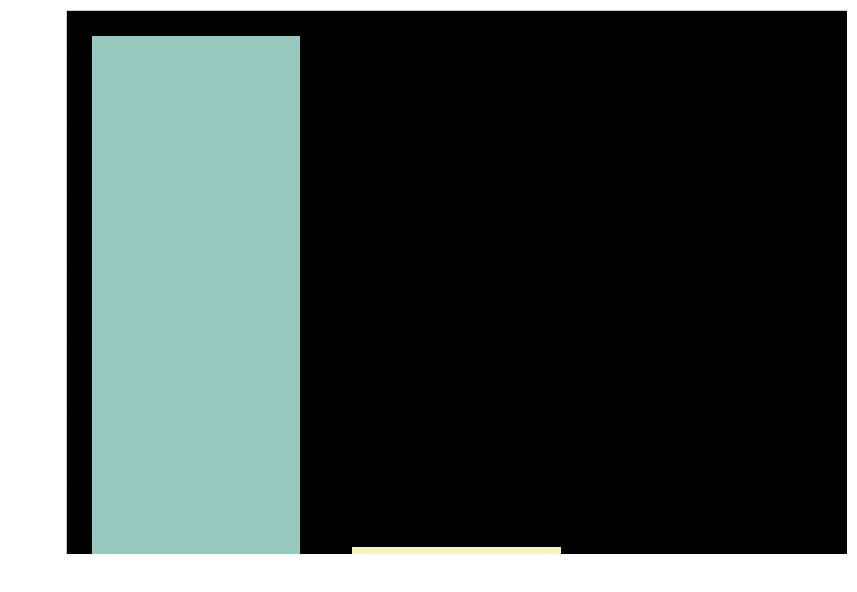

In [45]:
group_bar_plot( raw_df, 'redCards' )

There are realtively few redcards in the data, with even fewer having more than 1.

Now let's look at yellows

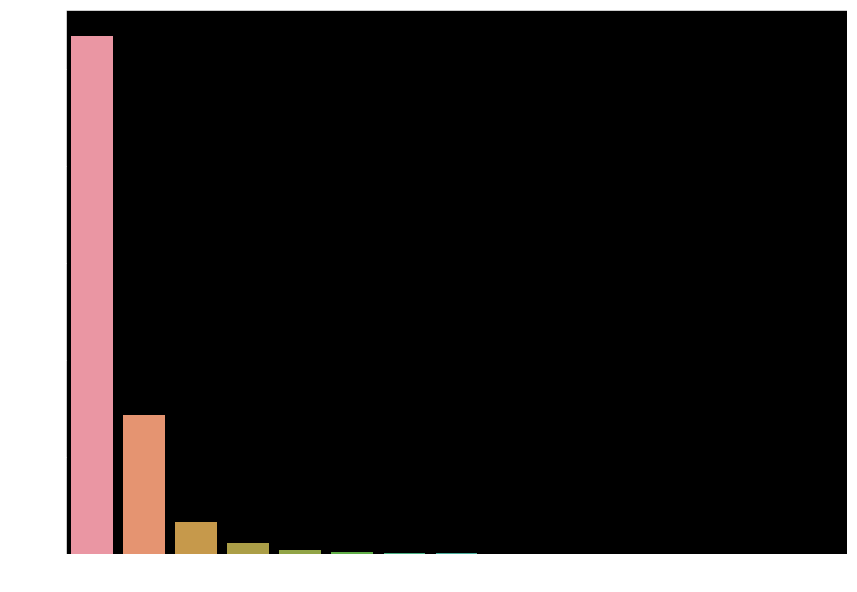

In [46]:
group_bar_plot( raw_df, 'yellowCards' )

Lots of yellow cards

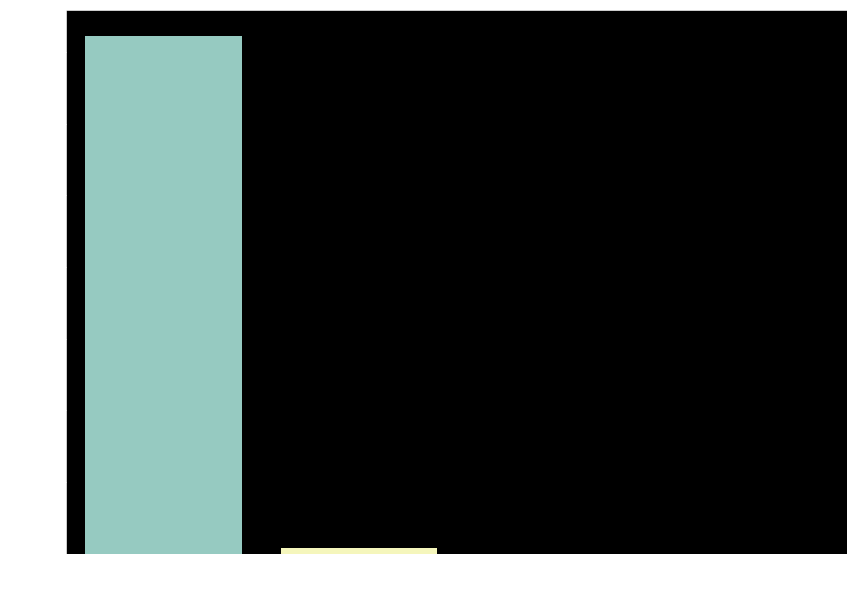

In [49]:
group_bar_plot( raw_df, 'yellowReds' )

Yellow reds is different than reds! We may want to consider the total number of reds

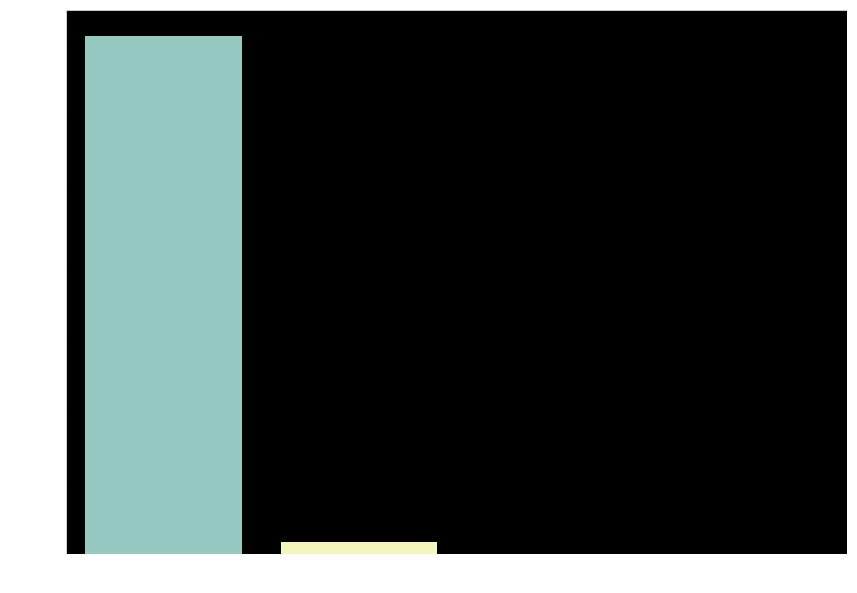

In [7]:
raw_df['tot_reds'] = raw_df['redCards'] + raw_df['yellowReds']
group_bar_plot( raw_df, 'tot_reds' )

Now let's look at skin color ratings

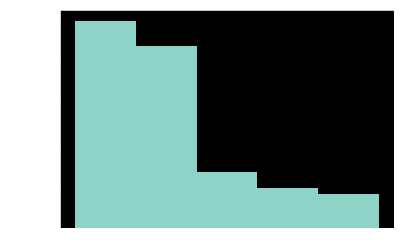

In [8]:
raw_df['rater1'].plot.hist( bins=5 )
plt.show()

In [10]:
np.max(raw_df['rater1'])

1.0

In [11]:
np.min(raw_df['rater1'])

0.0

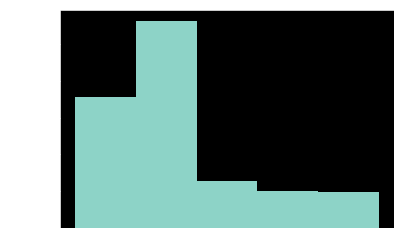

In [54]:
raw_df['rater2'].plot.hist( bins=5 )
plt.show()

Looks like rater 1 and 2 differ, we probably want to consider an average.

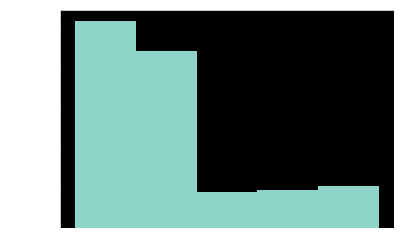

In [12]:
raw_df['rater_avg'] = ( raw_df['rater1'] + raw_df['rater2'] ) / 2.
raw_df['rater_avg'].plot.hist( bins=5 )
plt.show()

Still a skewed distribution, but that's alright. We need some kind of single metric for this.

In [13]:
diff = abs(raw_df['rater1'] - raw_df['rater2'])

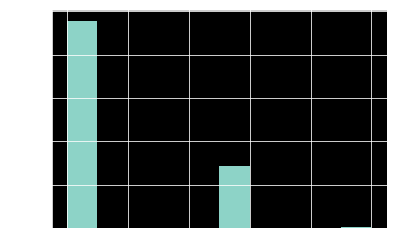

In [14]:
diff.hist()

The raters tend to agree perfectly, disagreeing by one rating point on ~25% of the players.  An average score between the two will be just fine.

In [15]:
raw_df['refCountry'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161])

That's a lot of different countries. Let's have a look at the distribution

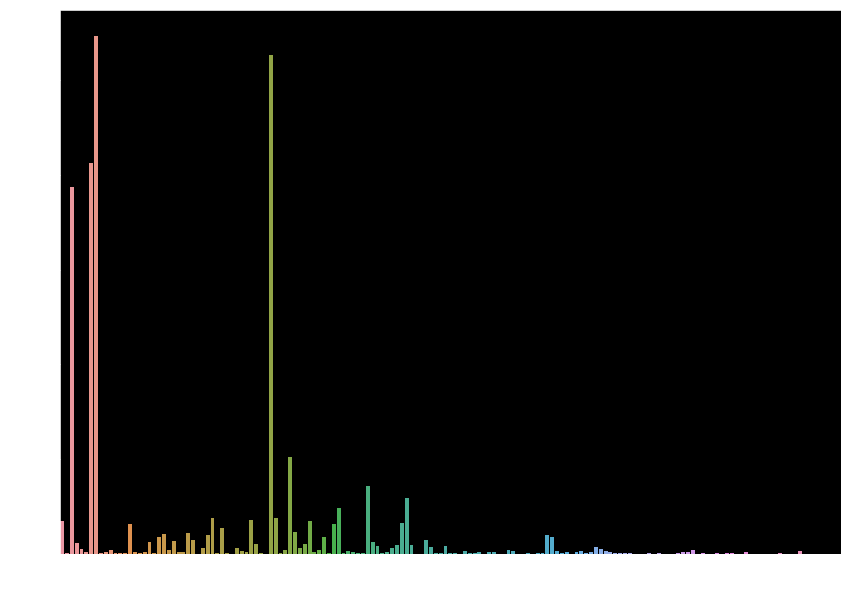

In [48]:
group_bar_plot( raw_df, 'refCountry' )

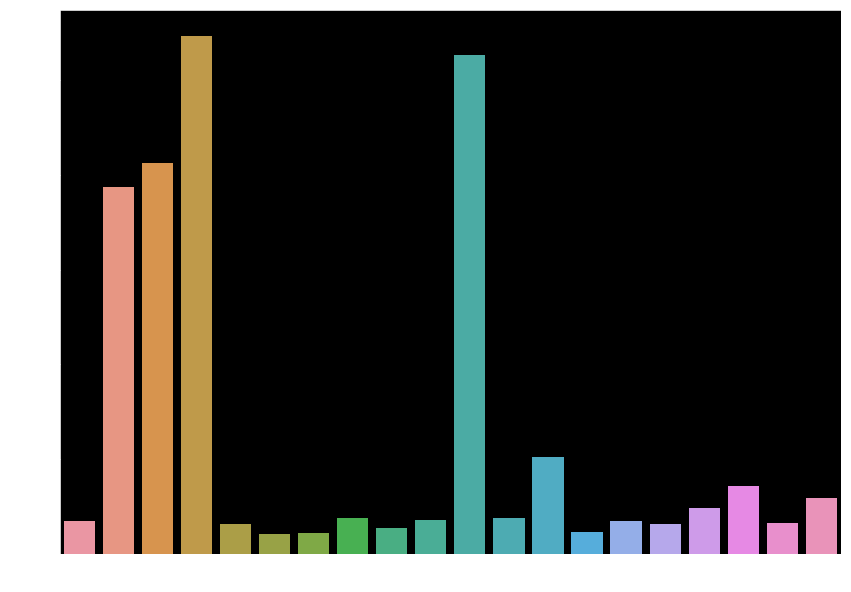

In [33]:
country_group = raw_df.groupby( ['refCountry'] ).size().reset_index()
country_group['count'] = country_group[0]

ind = country_group['count'] > 1000

fig, ax = plt.subplots( figsize=(14,10) )
sns.barplot( data=country_group.loc[ind,:], x='refCountry', y='count', ax=ax )
plt.show()

Only a handful of countries have more than 1000 games reffed. The vast majority is below this number

In [29]:
df=raw_df
df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'tot_reds', 'rater_avg'],
      dtype='object')

In [25]:
players = df.groupby('playerShort')

In [27]:
pos=players.position.first()

In [28]:
type(pos)

pandas.core.series.Series

In [65]:
height = players.height.mean()
weight = players.weight.mean()
tot_reds = players.tot_reds.sum()
rating = players.rater_avg.mean()
names = players.playerShort.first()

In [66]:
names.shape

(2053,)

In [78]:
names[0:15]

playerShort
aaron-hughes                        aaron-hughes
aaron-hunt                            aaron-hunt
aaron-lennon                        aaron-lennon
aaron-ramsey                        aaron-ramsey
abdelhamid-el-kaoutari    abdelhamid-el-kaoutari
abdon-prats                          abdon-prats
abdou-dampha                        abdou-dampha
abdou-traore_2                    abdou-traore_2
abdoul-camara                      abdoul-camara
abdoulaye-diallo_2            abdoulaye-diallo_2
abdoulaye-diallo_3            abdoulaye-diallo_3
abdoulaye-keita_2              abdoulaye-keita_2
abdoulaye-sane                    abdoulaye-sane
abdoulwhaid-sissoko          abdoulwhaid-sissoko
abdul-rahman-baba              abdul-rahman-baba
Name: playerShort, dtype: object

In [76]:
names[0]

'aaron-hughes'

In [81]:
df=pd.DataFrame()

In [82]:
df['names'] = names

In [83]:
df['height'] = height

In [84]:
df['tot_reds'] = tot_reds

In [85]:
df['rating'] = rating

In [86]:
df['weight'] = weight

In [87]:
df.shape

(2053, 5)

In [88]:
df.columns

Index(['names', 'height', 'tot_reds', 'rating', 'weight'], dtype='object')

In [89]:
df.iloc[0,0]

'aaron-hughes'

In [91]:
df['rating'].unique()

array([0.125, 0.25 , 0.   ,   nan, 0.75 , 0.875, 1.   , 0.375, 0.5  ,
       0.625])

In [100]:
raw_df[raw_df.rater1.notnull() & raw_df.rater2.isnull()].player.count()

0

In [101]:
raw_df[raw_df.rater1.isnull() & raw_df.rater2.notnull()].player.count()

0

Great, a player has either two skin ratings or none.  Drop those missing a skin tone rating

In [103]:
df.dropna(subset=['rating'], axis=0, inplace=True)

In [104]:
df.shape

(1585, 5)

In [105]:
df.rating.unique()

array([0.125, 0.25 , 0.   , 0.75 , 0.875, 1.   , 0.375, 0.5  , 0.625])

In [115]:
avg_cards = {}
pop_count = {}
for tone in df.rating.unique():
    avg_cards[tone] = df[df.rating==tone].tot_reds.sum()/df[df.rating==tone].rating.count()
    pop_count[tone] = df[df.rating==tone].rating.count()

In [110]:
avg_cards

{0.0: 1.794811320754717,
 0.125: 1.7312775330396475,
 0.25: 2.2012711864406778,
 0.375: 2.25974025974026,
 0.5: 1.9051724137931034,
 0.625: 1.1515151515151516,
 0.75: 1.7211538461538463,
 0.875: 1.825,
 1.0: 2.3260869565217392}

In [111]:
cards_per_player = pd.Series(avg_cards)

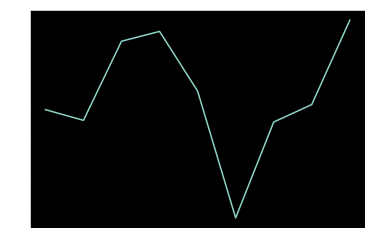

In [114]:
cards_per_player.plot()

In [116]:
pop_count

{0.0: 424,
 0.125: 227,
 0.25: 472,
 0.375: 77,
 0.5: 116,
 0.625: 33,
 0.75: 104,
 0.875: 40,
 1.0: 92}

In [118]:
df['skin'] = 'M'

In [119]:
df.loc[df.rating < 0.25, 'skin'] = 'L'

In [120]:
df.loc[df.rating > 0.375, 'skin'] = 'D'

In [122]:
df['skin'][0:15]

playerShort
aaron-hughes              L
aaron-hunt                L
aaron-lennon              M
aaron-ramsey              L
abdelhamid-el-kaoutari    M
abdou-traore_2            D
abdoulaye-diallo_2        D
abdoulaye-keita_2         D
abdoulwhaid-sissoko       D
abdul-rahman-baba         D
abdul-razak               D
abel-aguilar              M
abelaziz-barrada          L
abou-diaby                D
adam-bodzek               M
Name: skin, dtype: object

In [152]:
skins = ['L','M','D']
cards=[]
for s in skins:
    cards.append(np.mean(df[df.skin==s].tot_reds))

In [146]:
cards

[1.7726574500768049, 2.209471766848816, 1.8831168831168832]

In [153]:
cards=pd.Series(cards,index=skins)

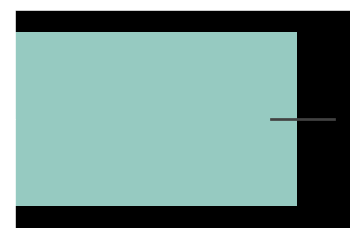

In [151]:
sns.barplot(x=cards)

In [154]:
cards = pd.DataFrame(cards)

In [137]:
cards

,0
L,1.772657
M,2.209472
D,1.883117


In [158]:
cards.reset_index()

,index,0
0,L,1.772657
1,M,2.209472
2,D,1.883117


In [175]:
cards.rename(columns={0:'cards'},inplace=True)

In [172]:
cards=cards.reset_index()

In [173]:
cards.rename(columns={'index':'tone'},inplace=True)

In [176]:
cards

,tone,cards
0,L,1.772657
1,M,2.209472
2,D,1.883117


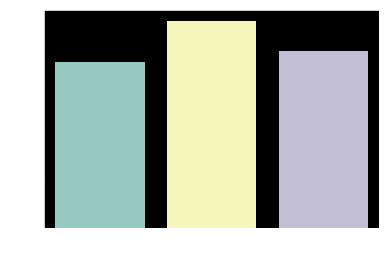

In [177]:
sns.barplot(x='tone',y='cards',data=cards)